# Diffusion-TS Tutorial

## Diffusion-TS: Interpretable Diffusion for General Time Series Generation

This notebook describes the user-guide of a time-series synthetic data generation application using Diffusion-TS framework.

## Necessary packages and functions call

In [1]:
import os
os.chdir("C:/Users/geminia/Desktop/Diffusion-TS-main - Copy")
import torch
import numpy as np

from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

### Build dataset and settings

In [2]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Config/stocks - Copy.yaml'
        self.save_dir = './toy_exp'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device) #This is only getting the PARAMS from Config 
teacher = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

### Training models

In [3]:
teacher.train()

  0%|          | 0/10 [00:00<?, ?it/s]

training complete


In [4]:
configs['model']['target'] = 'Models.interpretable_diffusion.distillation_diffusion.Diffusion_Distill' #Change the nn.Module! 

model = instantiate_from_config(configs['model']).to(device) #Instantiate the other model 

student1 = Trainer(config=configs, args=args, model=model, dataloader=dl_info) 
student1.model.load_state_dict(teacher.model.state_dict()) 
student1.model.teacher = teacher 

#Now sample from the trainer whilst training the student with different params ! 

In [5]:
student1.distill()


  0%|          | 0/10 [00:00<?, ?it/s]

training complete


In [6]:
configs['model']['params']['sampling_timesteps'] //= 2 

model = instantiate_from_config(configs['model']).to(device) #Instantiate the other model 

student2 = Trainer(config=configs, args=args, model=model, dataloader=dl_info) 
student2.model.load_state_dict(student1.model.state_dict()) 

student2.model.teacher = student1 #Specify who is the teacher 

In [7]:
student2.distill()

  0%|          | 0/10 [00:00<?, ?it/s]

training complete


In [10]:
configs['model']['params']['sampling_timesteps'] //= 2 

model = instantiate_from_config(configs['model']).to(device) #Instantiate the other model 

student3 = Trainer(config=configs, args=args, model=model, dataloader=dl_info) 
student3.model.load_state_dict(student2.model.state_dict()) 

student3.model.teacher = student2 #Specify who is the teacher 

In [11]:
student3.distill()

  0%|          | 0/10 [00:00<?, ?it/s]

training complete


In [13]:
configs['model']['params']['sampling_timesteps'] //= 2 

model = instantiate_from_config(configs['model']).to(device) #Instantiate the other model 

student4 = Trainer(config=configs, args=args, model=model, dataloader=dl_info) 
student4.model.load_state_dict(student3.model.state_dict()) 

student4.model.teacher = student3 #Specify who is the teacher 

In [14]:
student4.distill()

  0%|          | 0/10 [00:00<?, ?it/s]

training complete


In [12]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
#ori_data = np.load(os.path.join(dataset.dir, f"stock_ground_truth_{seq_length}_train.npy"))
ori_data = np.load(os.path.join(dataset.dir, f"stock_norm_truth_24_train.npy"))  # Uncomment the line if dataset other than Sine is used.
fake_data = student3.sample(num=len(dataset), size_every=2001, shape=[seq_length, feature_dim]) #all is the same, but with much less sampling steps.
if dataset.auto_norm:
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock.npy'), fake_data)

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

## Inference and Visualizations

### Sampling

In [ ]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
#ori_data = np.load(os.path.join(dataset.dir, f"stock_ground_truth_{seq_length}_train.npy"))
ori_data = np.load(os.path.join(dataset.dir, f"stock_norm_truth_24_train.npy"))  # Uncomment the line if dataset other than Sine is used.
fake_data = student4.sample(num=len(dataset), size_every=2001, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_stock.npy'), fake_data)

sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

### Visualization

We visualize the original and synthetic data distributions using PCA, tSNE and Density analysis.

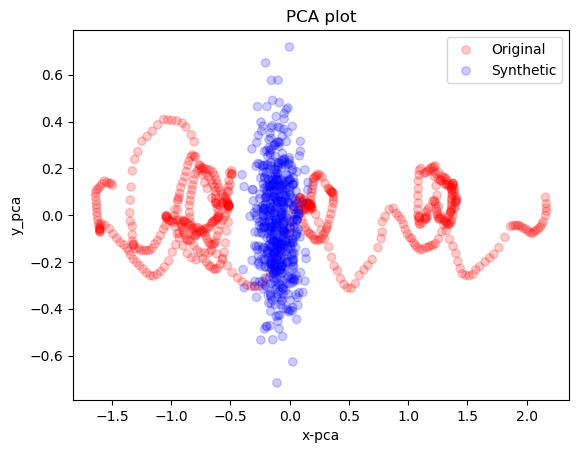

In [12]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=ori_data.shape[0])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1150 samples in 0.000s...
[t-SNE] Computed neighbors for 1150 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1150
[t-SNE] Computed conditional probabilities for sample 1150 / 1150
[t-SNE] Mean sigma: 0.152749
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.723667
[t-SNE] KL divergence after 300 iterations: 1.289949


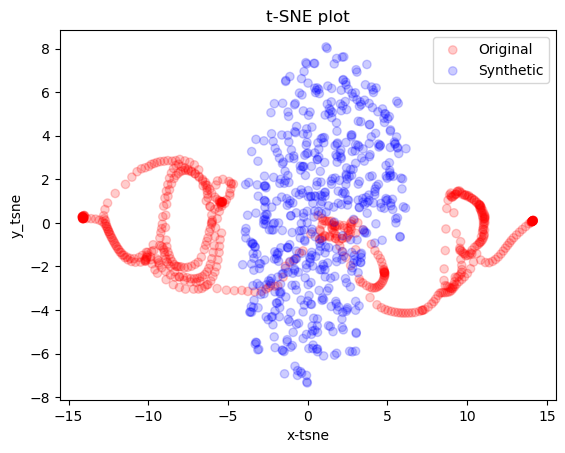

In [50]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', compare=ori_data.shape[0])

c:\Users\geminia\Desktop\Diffusion-TS-main\Utils\metric_utils.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
c:\Users\geminia\Desktop\Diffusion-TS-main\Utils\metric_utils.py:158: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de441

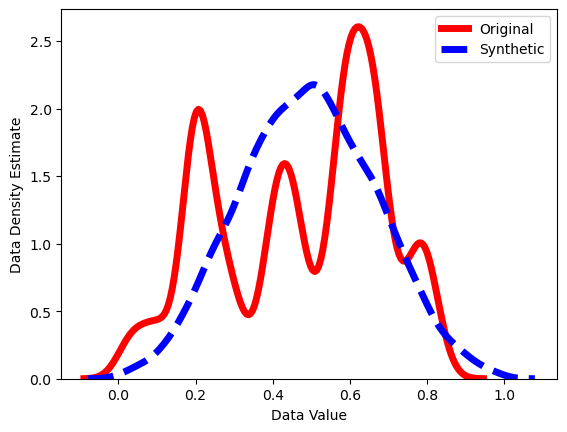

In [51]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=ori_data.shape[0])